# Разработка A/B-тестирования и анализ результатов

Я работаю продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных



- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработаем с историческими данными приложения:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest


In [ ]:
sessions_history = pd.read_csv('')

sessions_history.head()


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведим на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберем любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
# Cчитаем количество уникальных сессий
user_sessions_count = (sessions_history.groupby('user_id')['session_id'].nunique().reset_index())

#Пользователи с наибольшим количеством сессий
max_sessions = user_sessions_count['session_id'].max()
top_users = user_sessions_count[user_sessions_count['session_id'] == max_sessions]
print(top_users)

#Возьмем первого
top_user_id = top_users.iloc[0]['user_id']
top_user_data = sessions_history[sessions_history['user_id'] == top_user_id]
top_user_data

                user_id  session_id
8948   10E0DEFC1ABDBBE0          10
55627  6A73CB5566BB494D          10


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

- Агрегируем исторические данные и рассчитаем число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считаем, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразим их на одном графике.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

In [4]:
#Выделим дату
sessions_history['date'] = pd.to_datetime(sessions_history['session_start_ts']).dt.date
# Агрегируем данные
agg_users = (
    sessions_history
    .groupby('date')
    .agg(
        unique_users=('user_id', 'nunique'),
        registered_users=('registration_flag', lambda x: x.sum())  
    )
    .reset_index()
)

agg_users.head()


,date,unique_users,registered_users
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840


Можно заметить, что с каждым новым днем число уникальных пользователей и число зарегистрированных пользователей растет. Однако число пользователей, которые зарегистрировались, всегда сильно меньше. 

Рассмотрим подробнее на графике.

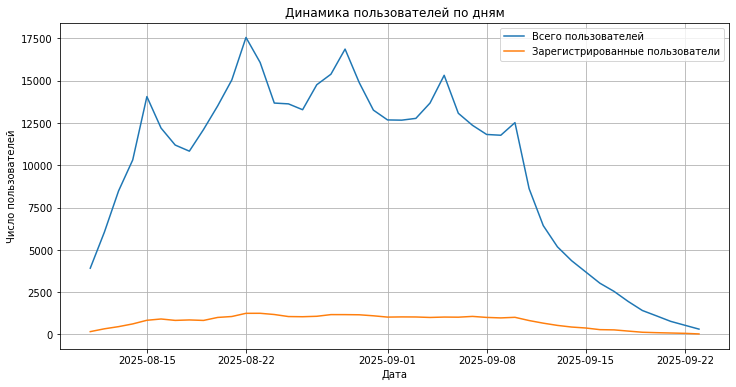

In [5]:
plt.figure(figsize=(12, 6))

# все пользователи
plt.plot(agg_users["date"], agg_users["unique_users"], label="Всего пользователей")

# зарегистрированные пользователи
plt.plot(agg_users["date"], agg_users["registered_users"], label="Зарегистрированные пользователи")

plt.title("Динамика пользователей по дням")
plt.xlabel("Дата")
plt.ylabel("Число пользователей")
plt.legend()
plt.grid(True)

plt.show()


Рассмотрим всех пользователей:Видно, что число пользователей росло с начала периода и достигло пика 22 августа - 17500 человек, после чего начался постепенный спад с редкими всплесками. К концу сентября количество пользователей резко снизилось практически до нуля.

Рассмотрим зарегистрированных пользователей: Динамика почти такая же, как и рассмотренное выше, но на меньших масштабах (примерно 169–1500 пользователей в день, что примерно в 16 раз меньше, чем общее число пользователей). Пик также приходится на 22 августа, после чего следует снижение с редкими всплесками.

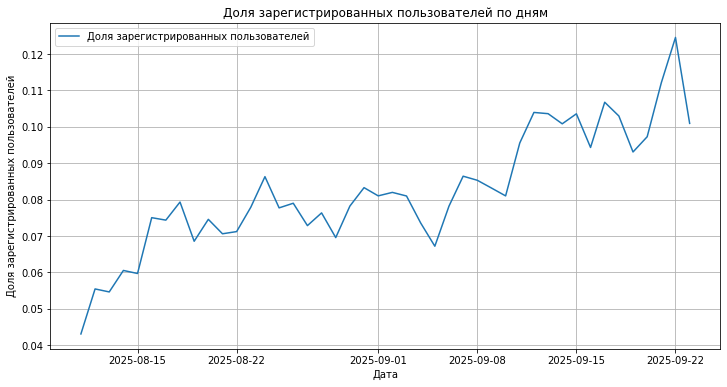

In [6]:
# Доля зарегистрированных пользователей
agg_users["registered_share"] = agg_users["registered_users"] / agg_users["unique_users"]

plt.figure(figsize=(12, 6))
plt.plot(agg_users["date"], agg_users["registered_share"], label="Доля зарегистрированных пользователей")

plt.title("Доля зарегистрированных пользователей по дням")
plt.xlabel("Дата")
plt.ylabel("Доля зарегистрированных пользователей")
plt.legend()
plt.grid(True)

plt.show()

В начале периода доля зарегистрированных пользователей была около 3%.
Уже к середине августа доля выросла до 7%.
С течением времени доля зарегистрированных пользователей постоянно росла, слегка колеблясь в низ, однако это не критично.
Сильный спад был зарегистрирован примерно с 1 по 8 сентября, однако больше не было резких и сильно падающих скачков.
Во второй половине сентября доля зарегистрированных пользователей ещё больше увеличивается, достигая пикового значения около 13% к концу периода.
К концу сентября зарегистрированных пользователей было примерно в 3 раза больше в долевом отношении, чем в начале периода.
Несмотря на то что общее количество пользователей снижалось после пика в августе, доля зарегистрированных пользователей постепенно росла.
Это говорит о том, что качество аудитории улучшалось: среди пользователей всё чаще встречались те, кто проходил регистрацию.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдем количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

In [7]:
# Количество сессий для каждого значения количества просмотренных страниц
page_counts = (sessions_history.groupby('page_counter')['session_id']
               .count().reset_index(name ='sessions_count')
               .sort_values('page_counter'))

page_counts 


,page_counter,sessions_count
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


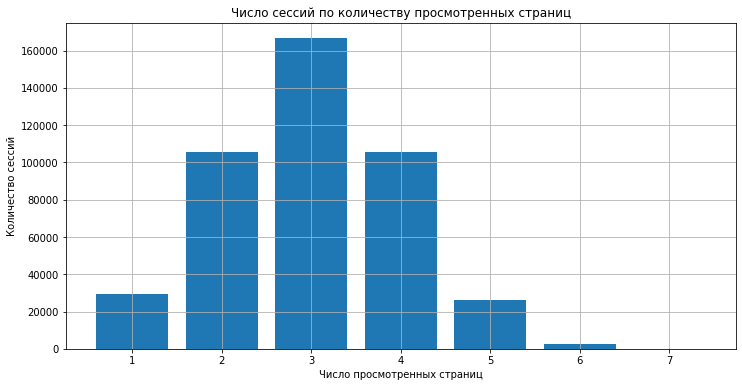

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(page_counts['page_counter'], page_counts['sessions_count'])

plt.title('Число сессий по количеству просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(True)

plt.show()

Можно заметить, что график имеет равномерное распределение с пиком в 3 страницы.
Разберем подробнее каждое количество страниц:


1 страница — 29 160 сессий. Это те пользователи, которые зашли и почти сразу вышли, минимально взаимодействуя с приложением.

2 страницы — 105 536 сессий, пользователи, которые не просто зашли в приложение, но еще и выполнили дополнительное дейстие.

3 страницы — 166 690 сессий. Пик активности приходится именно на 3 страницы, что указывает на наиболее распространённый сценарий использования.

4 страницы — 105 569 сессий, все еще много, однако с этого количества страниц начинается спадю почти такое же кол-во,как на двух страницах.

5 страниц — 26 288 сессий, резкое снижение, по сравнению с 4 страницами, но близко по значению к количеству пользователей, просмотревших 1 страницу.

6 страниц — всего 2 589 сессий,на страницах 6 и 7 у нормального распределения появляется дополнительный  маленький хвост.

7 страниц — всего 92 сессии, то есть практически единичные случаи. 

Стоит сосредоточиться на том, чтобы мотивировать пользователей задерживаться дольше и переходить за порог 3+ страниц, потому что именно здесь начинается заметное снижение.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [9]:
sessions_history["good_session"] = (sessions_history["page_counter"] >= 4).astype(int)

sessions_history.head()


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,date,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,2025-08-15,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,2025-08-15,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,2025-08-15,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,2025-08-15,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,2025-08-15,0


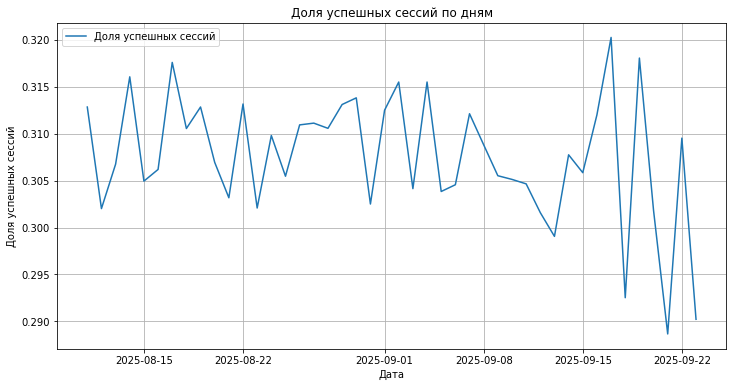

In [10]:
# Средняя доля good_session по дням
daily_good_sessions = (sessions_history.groupby('date')['good_session'].mean().reset_index())

plt.figure(figsize=(12, 6))
plt.plot(daily_good_sessions['date'], daily_good_sessions['good_session'], label = 'Доля успешных сессий')

plt.title('Доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.legend()
plt.grid(True)

plt.show()

Можно заметить, что доля успешных сессий не имеет постоянного значения в разные дни, а постоянно скачит в промежутке с 0.3 до 0.317, а под конец сентября имеет критически мальнькие значения.
Самое низкое значение было зафиксировано примерно 20 сентября - меньше 0.29, но при этом самое высокое - примерно 17 сентября примерно 0.32. Примерно в промежутке с 15 по 23 сентября значения максимально сильно скачут между собой. Скорее всего этот промежуток стоит исследовать отдельно, возможно там происходили какие-то акции, праздники или другие мероприятия, которые могли сподвигнуть людей заходить с такой периодичностью.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.


Цель эксперимента — проверить, способствует ли новый алгоритм росту вовлечённости пользователей, то есть увеличению времени и количества просматриваемого контента пользователем, и, как следствие, может ли новый алгоритм положительно влиять на ключевые бизнес-метрики (удержание, количество просмотров, выручка).

Сформулируем нулевую и альтернативную гипотезы:






Нулевая гипотеза(Н0): Новый алгоритм рекомендаций не влияет на вовлеченность пользователей (μ1=μ2).
Альтернативная гипотеза(Н1): Новый алгоритм рекомендаций увеличивает или уменьшает вовлеченность пользователей (μ1 =! μ2).

#### 2.2. Расчёт размера выборки


In [11]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03 * p1  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используем данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитаем длительность теста, разделив одно на другое.

- Рассчитаем среднее количество уникальных пользователей приложения в день.

- Определим длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлим в большую сторону.

In [12]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round((sessions_history.groupby('date')['user_id'].nunique().mean()), 2)

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil((sample_size * 2) / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.36 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считаем и сохраним в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. Построим удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [13]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Приведем к дате
sessions_test_part['date'] = pd.to_datetime(sessions_test_part['session_start_ts']).dt.date

# Первый день теста
first_day = sessions_test_part['date'].min()
first_day

datetime.date(2025, 10, 14)

In [14]:
day_data = sessions_test_part[sessions_test_part['date'] == first_day]

# Уникальные пользователи в каждой группе
unique_users_per_group = (day_data.groupby('test_group')['user_id'].nunique().reset_index())
unique_users_per_group

,test_group,user_id
0,A,1477
1,B,1466


Процентная разница в количестве пользователей между группами: 0.74%


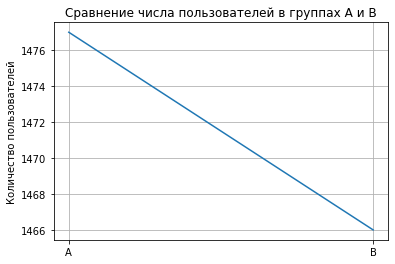

In [15]:
# Количество пользователей в группах
users_a = unique_users_per_group[unique_users_per_group['test_group'] == 'A']['user_id'].iloc[0]
users_b = unique_users_per_group[unique_users_per_group['test_group'] == 'B']['user_id'].iloc[0]

# Процентная разница
P = 100 * abs(users_a - users_b) / users_a
print(f"Процентная разница в количестве пользователей между группами: {P:.2f}%")

plt.plot(['A', 'B'], [users_a, users_b])
plt.title('Сравнение числа пользователей в группах A и B')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.show()


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [16]:
users_a_set = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
users_b_set = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])

# Находим пересечение множеств
common_users = users_a_set.intersection(users_b_set)

print(f"Количество пользователей, которые попали в обе группы: {len(common_users)}")

Количество пользователей, которые попали в обе группы: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.



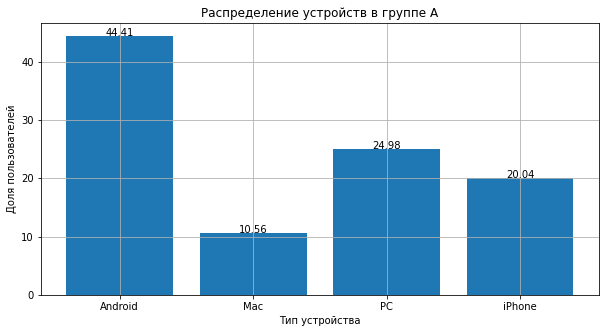

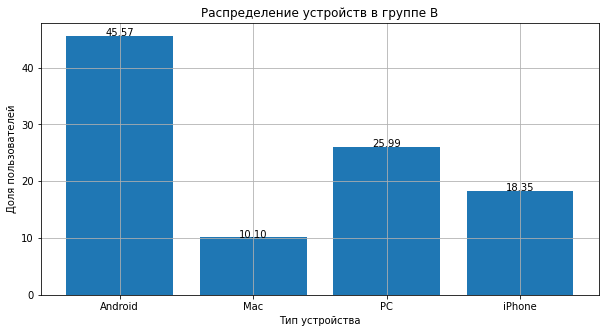

In [17]:
# Доли устройств для A
device_a = (
    sessions_test_part[sessions_test_part['test_group'] == 'A']
    .groupby('device')['user_id']
    .nunique()
)
device_a = device_a / device_a.sum() * 100

# Доли устройств для B
device_b = (
    sessions_test_part[sessions_test_part['test_group'] == 'B']
    .groupby('device')['user_id']
    .nunique()
)
device_b = device_b / device_b.sum() * 100
# Диаграмма A
plt.figure(figsize=(10, 5))
plt.bar(device_a.index, device_a.values)
plt.title('Распределение устройств в группе A')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.grid(True)
for i, v in enumerate(device_a.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()

# Диаграмма B
plt.figure(figsize=(10, 5))
plt.bar(device_b.index, device_b.values)
plt.title('Распределение устройств в группе B')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей')
plt.grid(True)
for i, v in enumerate(device_b.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.show()

Распределение пользователей по типу устройства очень близко между группами A и B.
Нет резких отличий, которые могли бы повлиять на результаты A/B-теста.
Можно считать, что группы сбалансированы.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.


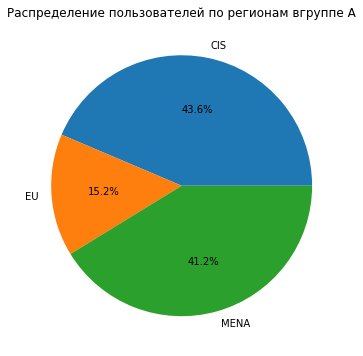

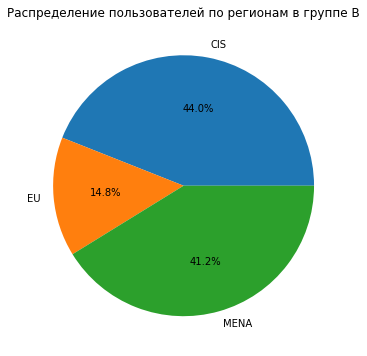

In [18]:
# Доли устройств для A
region_a = (
    sessions_test_part[sessions_test_part['test_group'] == 'A']
    .groupby('region')['user_id']
    .nunique()
)
region_a = region_a / region_a.sum() * 100

# Доли устройств для B
region_b = (
    sessions_test_part[sessions_test_part['test_group'] == 'B']
    .groupby('region')['user_id']
    .nunique()
)
region_b = region_b / region_b.sum() * 100

# Круговая A
plt.figure(figsize=(6,6))
plt.pie(region_a.values, labels=region_a.index, autopct='%1.1f%%')
plt.title("Распределение пользователей по регионам вгруппе A")
plt.show()

# Круговая B 
plt.figure(figsize=(6,6))
plt.pie(region_b.values, labels=region_b.index, autopct='%1.1f%%')
plt.title("Распределение пользователей по регионам в группе B")
plt.show()


Распределение пользователей по регионам очень близко между группами A и B.
Нет значимых различий, которые могли бы повлиять на результаты A/B-теста.
Можно считать, что группы сбалансированы

#### 3.5. Вывод после проверки A/B-теста



Было обнаружено различие в количестве пользователей в двух группах. В группе A было 1477 человек на момент первого дня, а в группе B - 1466 человек, что меньше на 0.74%. 

В двух группах не было обнаружено людей, которые попали в обе группы сразу. 

В тестовой и контрольной группах сохранилось равномерное распределение по устройствам. В группе A Android занимает 44.4%, в группе B - 45.5; PC в группе A занимает 24.9%, в группе B - 25.9; iphone в группе A занимает 20%, в группе B - 18.3%; Mac в группе A занимает 10.5%, в группе B - 10.1%. 

Значения в обеих группах практически не отличаются. Рассмотрим значения по регионам. В группе A CIS занимает 43.6%, в группе B - 44%; MENA в группе A занимает 41.2%, в группе B - 41.2; EU в группе A занимает 15.2%, в группе B - 14.8%. Распределение можно считать равномерным

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у нас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считаем и сохраняем в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [19]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

sessions_test["good_session"] = (sessions_test["page_counter"] >= 4).astype(int)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и мы будем сравнивать две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведим на экран полученное значение p-value и интерпретируем его.

In [20]:
# Приведем к дате
sessions_test['date'] = pd.to_datetime(sessions_test['session_date']).dt.date

# Группировка
daily_sessions = (sessions_test.groupby(['date', 'test_group'])['session_id']
    .nunique().reset_index())

daily_sessions

,date,test_group,session_id
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280
5,2025-10-16,B,3241
6,2025-10-17,A,4089
7,2025-10-17,B,4054
8,2025-10-18,A,5013
9,2025-10-18,B,5059


H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.
 
 
H₁ (альтернативная гипотеза) — количество уникальных дневных сессий различается между тестовой и контрольной группами.

In [21]:
metric_a = daily_sessions[daily_sessions['test_group'] == 'A']['session_id']
metric_b = daily_sessions[daily_sessions['test_group'] == 'B']['session_id']

alpha = 0.05

# t-тест Уэлча, односторонний 
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False,
    )

if p_value_welch_ttest > alpha:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Интерпретация: Нулевая гипотеза подтверждается.  Количество уникальных дневных сессий не различается между тестовой и контрольной группами')
else:
    print(f'p-value теста Уэлча = {round(p_value_welch_ttest, 2)}')
    print('Интерпретация: Нулевая гипотеза не подтверждается. Количество уникальных дневных сессий различается между тестовой и контрольной группами.')

p-value теста Уэлча = 0.94
Интерпретация: Нулевая гипотеза подтверждается.  Количество уникальных дневных сессий не различается между тестовой и контрольной группами


#### 4.3. Сравнение доли успешных сессий

Рассчитаем долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразим на экране.

In [22]:
# Группировка по тестовой группе и вычисление среднего значения good_session
success_rate = sessions_test.groupby('test_group')['good_session'].mean().reset_index()
success_rate.rename(columns={'good_session': 'success_rate'}, inplace = True)

# Разница между группами
success_a = success_rate.loc[success_rate['test_group'] == 'A', 'success_rate'].values[0]
success_b = success_rate.loc[success_rate['test_group'] == 'B', 'success_rate'].values[0]
difference = success_b - success_a

# Вывод 
print(success_rate)
print(f"Разница долей успешных сессий (B - A): {difference:.4f}")


  test_group  success_rate
0          A      0.307723
1          B      0.318290
Разница долей успешных сессий (B - A): 0.0106


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге мы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведим на экран полученное значение p-value и свои выводы о статистической значимости. 

In [23]:
n_a = sessions_test[sessions_test['test_group'] == 'A'].shape[0]
n_b = sessions_test[sessions_test['test_group'] == 'B'].shape[0]
m_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].sum()
m_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].sum()

# z-тест
alpha = 0.05
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='two-sided')


if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение. Новый алгоритм рекомендаций не влияет на вовлеченность пользователей.')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения. Новый алгоритм рекомендаций влияет вовлеченность пользователей.')

pvalue=0.0003149479976072246 < 0.05
Нулевая гипотеза не находит подтверждения. Новый алгоритм рекомендаций влияет вовлеченность пользователей.


#### 4.5. Вывод по результатам A/B-эксперимента


Эксперимент проводился в период с 14 октября по 2 ноября 2025 года. Пользователи были разделены на контрольную и тестовую группы. Необходимый размер выборки для каждой группы составил 41040 человек.

Ключевая метрика — доля успешных сессий (сессия считается успешной, если просмотрено больше 3 страниц). В тестовой группе с новым алгоритмом рекомендаций доля успешных сессий оказалась примерно на 1.1% выше, чем в контрольной группе.

По результатам применения t-теста было выявлено, что количество уникальных дневных сессий не различается между тестовой и контрольной группами.

По результатам применения z-теста, где проверялось, является ли изменение в метрике доли успешных сессий статистически значимым, было получено 0.0003 < 0.05, что означает, что новый алгоритм рекомендации влияет вовлеченность пользователей.

Да, тест показал статистически значимое влияние нового алгоритма на вовлечённость.
Но решение о внедрении стоит принимать только после проведения дополнительных тестов.